# Exploración de la base de datos SaberPro (2021-2024)
Este notebook realiza una exploración inicial de la base de datos SQLite `SaberPro2021_2024.db`.
Incluye:
- Resumen de las tablas
- Distribución de variables clave (género, etnia)
- Estadísticas descriptivas de puntajes
- Visualizaciones de relaciones entre puntajes
- Evolución de los puntajes promedio por año


## Análisis univariado 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy import stats
import prince


# Estilos de gráficos
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [2]:
# Conectar con la base de datos
nombre_db = "SaberPro2021_2024.db"
try:
    conn = sqlite3.connect(nombre_db)
    cursor = conn.cursor()
    print(f"Conexión exitosa con {nombre_db}")
except Exception as e:
    print("Error al conectar con la base de datos:", e)

Conexión exitosa con SaberPro2021_2024.db


In [3]:
# Listado de tablas a explorar
tables = ["dim_estudiante", "dim_institucion", "dim_programa", "dim_tiempo", "dim_familia", "fact_resultados"]

for t in tables:
    try:
        df = pd.read_sql(f"SELECT * FROM {t}", conn)
        print(f"\nTabla: {t}")
        print("Registros totales:", len(df))
        print("Columnas:", list(df.columns))
    except Exception as e:
        print(f"Error al leer la tabla {t}:", e)


Tabla: dim_estudiante
Registros totales: 1015295
Columnas: ['id_estudiante', 'estu_consecutivo', 'estu_tipodocumento', 'estu_genero', 'estu_etnia', 'estu_nacionalidad', 'estu_fechanacimiento', 'estu_estudiante', 'estu_cursoiesexterna', 'estu_horassemanatrabaja']

Tabla: dim_institucion
Registros totales: 275
Columnas: ['id_institucion', 'inst_cod_institucion', 'inst_nombre_institucion', 'inst_departamento', 'inst_municipio', 'inst_caracter_academico', 'inst_origen']

Tabla: dim_programa
Registros totales: 4803
Columnas: ['id_programa', 'estu_snies_prgmacademico', 'estu_prgm_academico', 'estu_nivel_prgm_academico', 'estu_metodo_prgm', 'estu_nucleo_pregrado']

Tabla: dim_tiempo
Registros totales: 14
Columnas: ['id_tiempo', 'periodo', 'anio']

Tabla: dim_familia
Registros totales: 1015295
Columnas: ['id_familia', 'estu_consecutivo', 'fami_estratovivienda', 'fami_educacionpadre', 'fami_educacionmadre', 'fami_ocupacionpadre', 'fami_ocupacionmadre', 'fami_tieneinternet', 'fami_tienecomputad

In [4]:
# Verificación de metadatos y nulos 

fact = pd.read_sql("SELECT * FROM fact_resultados", conn)
resumen = pd.DataFrame({
    "tipo_dato": fact.dtypes,
    "nulos": fact.isnull().sum(),
    "duplicados": fact.duplicated().sum()
})

print("Resumen de calidad de datos:")
print(resumen)

Resumen de calidad de datos:
                          tipo_dato  nulos  duplicados
id_resultado                  int64      0           0
id_estudiante                 int64      0           0
id_institucion              float64  27478           0
id_programa                 float64  27480           0
id_familia                    int64      0           0
id_tiempo                     int64      0           0
mod_competen_ciudada_punt   float64      0           0
mod_comuni_escrita_punt     float64      0           0
mod_ingles_punt             float64    573           0
mod_lectura_critica_punt    float64      0           0
mod_razona_cuantitat_punt   float64      0           0



Distribución de género:
estu_genero
F    588790
M    426486
Name: count, dtype: int64


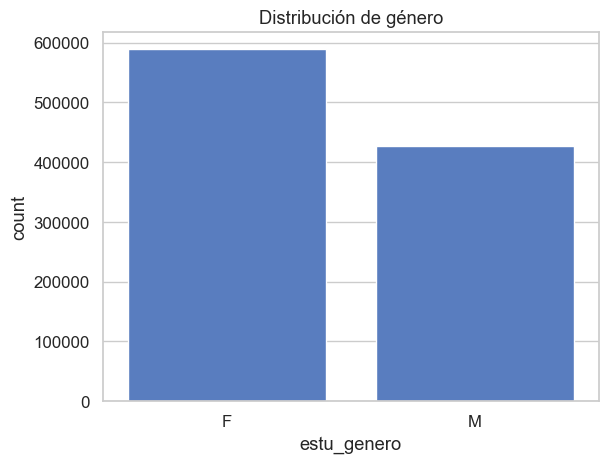

In [5]:
# Distribución de género en estudiantes (excluyendo 'L')
dim_estudiante = pd.read_sql("SELECT * FROM dim_estudiante WHERE estu_genero <> 'L'", conn)

print("\nDistribución de género:")
print(dim_estudiante["estu_genero"].value_counts(dropna=True))

sns.countplot(data=dim_estudiante, x="estu_genero",
              order=dim_estudiante["estu_genero"].value_counts().index)
plt.title("Distribución de género")
plt.show()


Distribución de etnia:
estu_etnia
Afrodescendiente                 22430
Zenu (Senu)                       3322
Pasto                             2561
Otro grupo étnico minoritario     2496
Wayúu                             2262
Raizal                            1209
Tikuna                            1143
Paez (Autodenominacion Nasa)      1139
Pijao                              910
Negritudes                         829
Name: count, dtype: int64


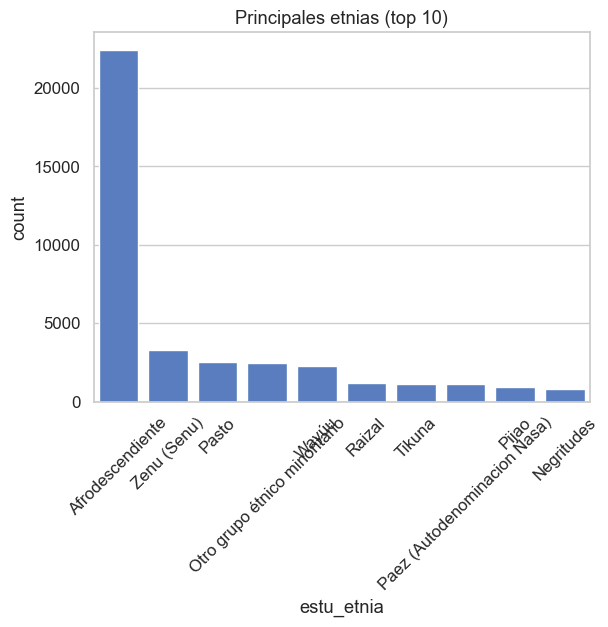

In [6]:
# Distribución de etnia (excluyendo 'Ninguno')
print("\nDistribución de etnia:")
print(dim_estudiante[dim_estudiante["estu_etnia"] != 'Ninguno']["estu_etnia"].value_counts(dropna=True).head(10))

sns.countplot(data=dim_estudiante[dim_estudiante["estu_etnia"] != 'Ninguno'],
              x="estu_etnia",
              order=dim_estudiante[dim_estudiante["estu_etnia"] != 'Ninguno']["estu_etnia"].value_counts().head(10).index)
plt.title("Principales etnias (top 10)")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Estadísticas descriptivas de los puntajes

print("\nEstadísticas descriptivas de los puntajes:")
print(fact[[
    "mod_competen_ciudada_punt", "mod_comuni_escrita_punt", 
    "mod_ingles_punt", "mod_lectura_critica_punt", 
    "mod_razona_cuantitat_punt"
]].describe().map(lambda x: f"{x:.0f}" if float(x).is_integer() else f"{x:.2f}"))


Estadísticas descriptivas de los puntajes:
      mod_competen_ciudada_punt mod_comuni_escrita_punt mod_ingles_punt  \
count                   1015295                 1015295         1014722   
mean                     142.84                  135.17          154.04   
std                       34.35                   44.59           34.40   
min                           0                       0               0   
25%                         118                     121             132   
50%                         143                     141             151   
75%                         168                     162             175   
max                         300                     300             300   

      mod_lectura_critica_punt mod_razona_cuantitat_punt  
count                  1015295                   1015295  
mean                    149.26                    143.53  
std                      31.06                     32.51  
min                          0              

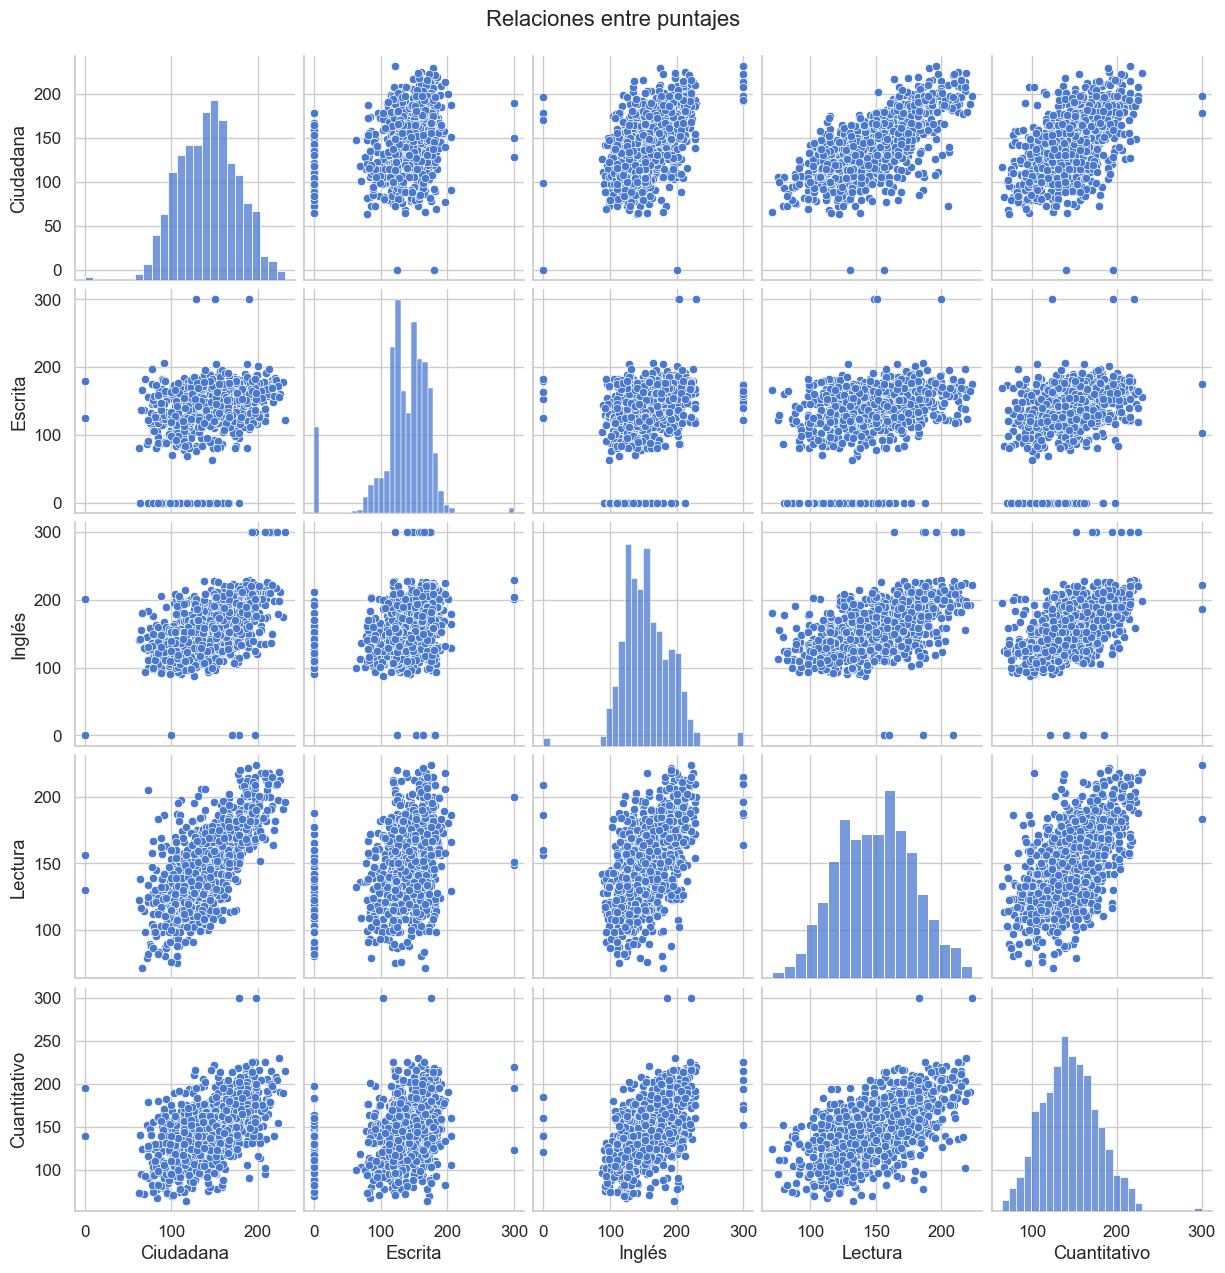

In [8]:
# Visualización de relaciones entre puntajes (muestra de 500)
sns.pairplot(fact[[
    "mod_competen_ciudada_punt", "mod_comuni_escrita_punt", 
    "mod_ingles_punt", "mod_lectura_critica_punt", 
    "mod_razona_cuantitat_punt"
]].rename(columns={
    "mod_competen_ciudada_punt": "Ciudadana",
    "mod_comuni_escrita_punt": "Escrita",
    "mod_ingles_punt": "Inglés",
    "mod_lectura_critica_punt": "Lectura",
    "mod_razona_cuantitat_punt": "Cuantitativo"
}).sample(1000, random_state=42))

plt.suptitle("Relaciones entre puntajes", y=1.02)
plt.show()

In [9]:
# Cruce: Puntaje global por año
query = '''
SELECT t.anio, 
       AVG(f.mod_competen_ciudada_punt) AS avg_ciudadana,
       AVG(f.mod_comuni_escrita_punt) AS avg_comunicacion,
       AVG(f.mod_ingles_punt) AS avg_ingles,
       AVG(f.mod_lectura_critica_punt) AS avg_lectura,
       AVG(f.mod_razona_cuantitat_punt) AS avg_razonamiento
FROM fact_resultados f
JOIN dim_tiempo t ON f.id_tiempo = t.id_tiempo
GROUP BY t.anio
ORDER BY t.anio;
'''
df_year = pd.read_sql(query, conn)
print("\nPromedios de puntaje por año:")
print(df_year)



Promedios de puntaje por año:
   anio  avg_ciudadana  avg_comunicacion  avg_ingles  avg_lectura  \
0  2021     143.068609        137.173516  153.579383   145.653312   
1  2022     143.428343        129.207653  154.694540   150.218158   
2  2023     139.372395        140.405398  152.874263   148.783899   
3  2024     145.224484        133.641915  154.964503   152.155848   

   avg_razonamiento  
0        143.337535  
1        145.075943  
2        142.600752  
3        143.268120  


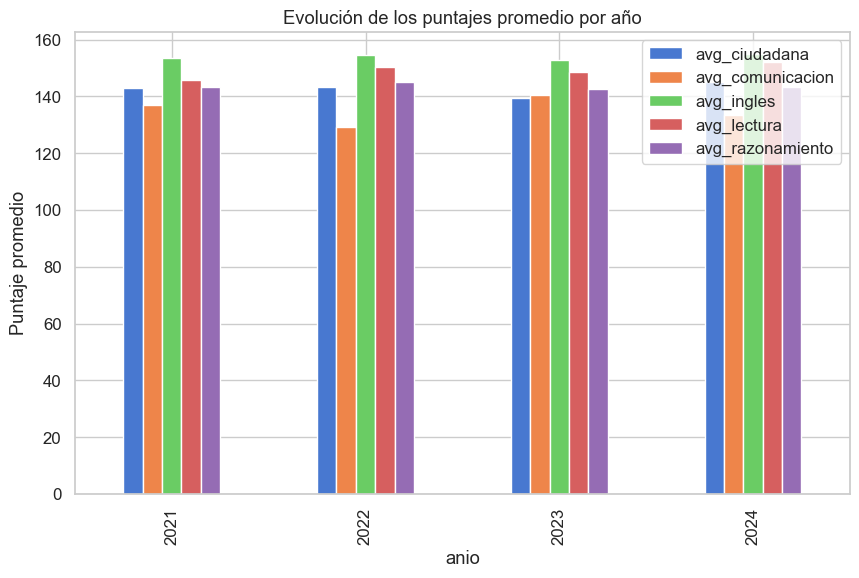

In [10]:

df_year.set_index("anio").plot(kind="bar", figsize=(10,6))
plt.title("Evolución de los puntajes promedio por año")
plt.ylabel("Puntaje promedio")
plt.show()

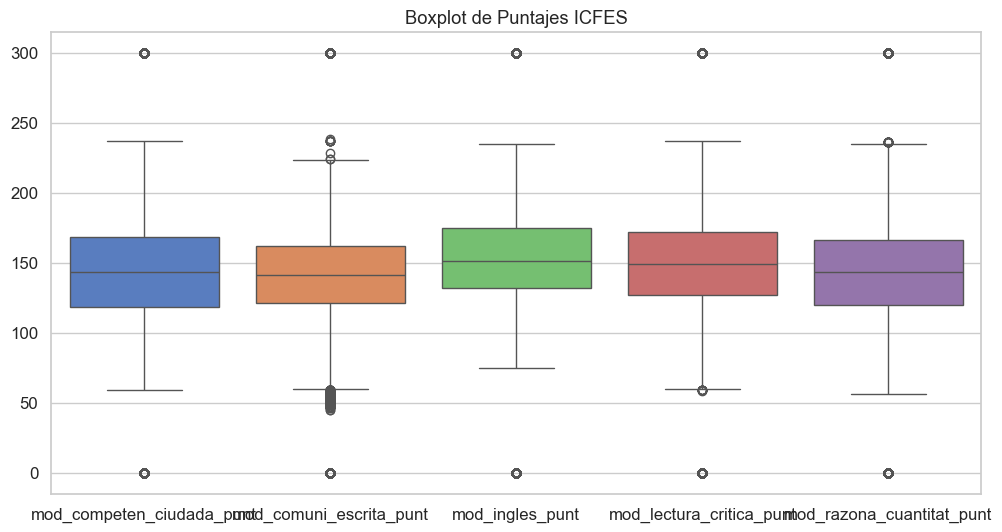

In [11]:

# Boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=fact[[
    "mod_competen_ciudada_punt","mod_comuni_escrita_punt",
    "mod_ingles_punt","mod_lectura_critica_punt",
    "mod_razona_cuantitat_punt"
]])
plt.title("Boxplot de Puntajes ICFES")
plt.show()


## Análisis Bivariado

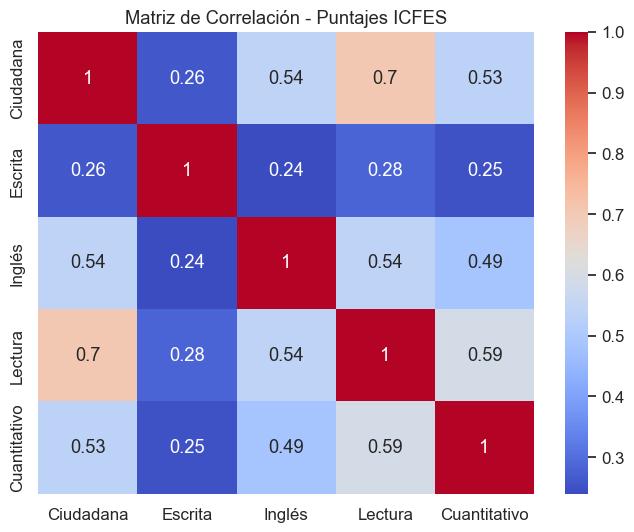

In [12]:
# Correlaciones
cor = fact[[
    "mod_competen_ciudada_punt", "mod_comuni_escrita_punt", 
    "mod_ingles_punt", "mod_lectura_critica_punt", 
    "mod_razona_cuantitat_punt"
]].rename(columns={
    "mod_competen_ciudada_punt": "Ciudadana",
    "mod_comuni_escrita_punt": "Escrita",
    "mod_ingles_punt": "Inglés",
    "mod_lectura_critica_punt": "Lectura",
    "mod_razona_cuantitat_punt": "Cuantitativo"
}).corr()
plt.figure(figsize=(8,6))
sns.heatmap(cor, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Puntajes ICFES")
plt.show()

In [13]:
def comparar_puntajes(df_fact, df_dim, join_key, cat_var, puntajes):
    """
    Hace comparaciones de puntajes por variable categórica.
    - df_fact: tabla fact
    - df_dim: dimensión a unir
    - join_key: llave primaria para merge
    - cat_var: variable categórica
    - puntajes: lista de puntajes numéricos
    """
    df = df_fact.merge(df_dim[[join_key, cat_var]], on=join_key)
    
    # Estadísticos descriptivos
    tabla = df.groupby(cat_var)[puntajes].agg(["mean", "std", "count"])
    print(f"\n--- {cat_var} ---")
    print(tabla)
    
    # Gráficos
    for puntaje in puntajes:
        plt.figure(figsize=(8,5))
        sns.boxplot(data=df, x=cat_var, y=puntaje)
        plt.title(f"{puntaje} según {cat_var}")
        plt.xticks(rotation=45)
        plt.show()
    
    # ANOVA o Kruskal (según normalidad)
    grupos = [vals.dropna().values for _, vals in df.groupby(cat_var)[puntajes[0]]]
    if all(len(g) > 1 for g in grupos):  # evitar errores con grupos vacíos
        stat, p = stats.f_oneway(*grupos)
        print(f"ANOVA para {puntajes[0]} ~ {cat_var}: F={stat:.3f}, p={p:.3g}")

In [14]:
def analizar_categoricas(df1, df2, join_key, var1, var2):
    """
    Tablas de contingencia y chi-cuadrado entre dos categóricas.
    """
    df = df1.merge(df2, on=join_key)
    tabla = pd.crosstab(df[var1], df[var2], margins=True, normalize="index")
    print(f"\n--- {var1} vs {var2} ---")
    print(tabla)
    
    # Heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(pd.crosstab(df[var1], df[var2], normalize="index"), annot=True, cmap="Blues")
    plt.title(f"{var1} vs {var2}")
    plt.show()
    
    # Chi-cuadrado
    chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(df[var1], df[var2]))
    print(f"Chi2={chi2:.3f}, p={p:.3g}, dof={dof}")

In [15]:
%%script false
puntajes = [
    "mod_competen_ciudada_punt", "mod_comuni_escrita_punt", 
    "mod_ingles_punt", "mod_lectura_critica_punt", 
    "mod_razona_cuantitat_punt"]

## a) dim_estudiante
comparar_puntajes(fact, dim_estudiante, "id_estudiante", "estu_genero", puntajes)
comparar_puntajes(fact, dim_estudiante, "id_estudiante", "estu_etnia", puntajes)

## b) dim_familia
comparar_puntajes(fact, dim_familia, "id_familia", "fami_estratovivienda", puntajes)
comparar_puntajes(fact, dim_familia, "id_familia", "fami_educacionmadre", puntajes)
comparar_puntajes(fact, dim_familia, "id_familia", "fami_educacionpadre", puntajes)
comparar_puntajes(fact, dim_familia, "id_familia", "fami_tieneinternet", puntajes)
comparar_puntajes(fact, dim_familia, "id_familia", "fami_tienecomputador", puntajes)

## c) dim_institucion
comparar_puntajes(fact, dim_institucion, "id_institucion", "inst_caracter_academico", puntajes)
comparar_puntajes(fact, dim_institucion, "id_institucion", "inst_origen", puntajes)

## d) dim_programa
comparar_puntajes(fact, dim_programa, "id_programa", "prog_nivel_academico", puntajes)
comparar_puntajes(fact, dim_programa, "id_programa", "prog_metodo", puntajes)
comparar_puntajes(fact, dim_programa, "id_programa", "prog_nucleo_pregrado", puntajes)

## e) dim_tiempo
comparar_puntajes(fact, dim_tiempo, "id_tiempo", "anio", puntajes)
comparar_puntajes(fact, dim_tiempo, "id_tiempo", "periodo", puntajes)

Couldn't find program: 'false'


In [16]:
%%script false
## a) dim_estudiante y dim_familia
analizar_categoricas(dim_estudiante, dim_familia, "id_familia", "estu_genero", "fami_tieneinternet")
analizar_categoricas(dim_estudiante, dim_familia, "id_familia", "estu_genero", "fami_estratovivienda")
analizar_categoricas(dim_estudiante, dim_familia, "id_familia", "estu_etnia", "fami_educacionmadre")
analizar_categoricas(dim_estudiante, dim_familia, "id_familia", "estu_etnia", "fami_educacionpadre")

## b) dim_institucion y dim_programa
analizar_categoricas(dim_institucion, dim_programa, "id_institucion", "inst_caracter_academico", "prog_metodo")
analizar_categoricas(dim_institucion, dim_programa, "id_institucion", "inst_origen", "prog_nivel_academico")

## c) dim_familia y dim_institucion
analizar_categoricas(dim_familia, dim_institucion, "id_institucion", "fami_estratovivienda", "inst_caracter_academico")
analizar_categoricas(dim_familia, dim_institucion, "id_institucion", "fami_tienecomputador", "inst_caracter_academico")

## d) dim_tiempo
analizar_categoricas(dim_tiempo, dim_programa, "id_tiempo", "periodo", "prog_metodo")

Couldn't find program: 'false'


## Análisis Multivariado

In [17]:
# Cargar dimensión familia
dim_familia = pd.read_sql("SELECT * FROM dim_familia", conn)

# Merge con dimensiones
df_merge = (
    fact
    .merge(
        pd.read_sql("SELECT id_estudiante, estu_genero FROM dim_estudiante", conn),
        on="id_estudiante", how="left"
    )
    .merge(
        pd.read_sql("SELECT id_institucion, inst_caracter_academico FROM dim_institucion", conn),
        on="id_institucion", how="left"
    )
    .merge(
        pd.read_sql("SELECT id_programa, estu_nivel_prgm_academico FROM dim_programa", conn),
        on="id_programa", how="left"
    )
    .merge(dim_familia, on="id_familia", how="left")
)

# Variables categóricas
cat_vars = [
    'fami_estratovivienda', 'fami_educacionpadre', 'fami_educacionmadre', 'fami_tieneinternet', 
    'fami_tienecomputador',"estu_genero", "inst_caracter_academico", "estu_nivel_prgm_academico"
]
# Variables numéricas
num_vars = [
    "mod_competen_ciudada_punt",
    "mod_comuni_escrita_punt",
    "mod_ingles_punt",
    "mod_lectura_critica_punt",
    "mod_razona_cuantitat_punt"
]

# Subconjunto para FAMD
df_famd = df_merge[num_vars + cat_vars].dropna()

# Ajustar modelo FAMD
famd = prince.FAMD(
    n_components=7,
    n_iter=3,
    copy=True,
    check_input=True,
    engine="sklearn",
    random_state=123
)

famd = famd.fit(df_famd)

In [18]:

# Varianza explicada
print("Varianza explicada por componente:")
print(famd.eigenvalues_summary)


Varianza explicada por componente:
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              9.844         6.61%                      6.61%
1              6.414         4.30%                     10.91%
2              5.537         3.72%                     14.63%
3              5.219         3.50%                     18.13%
4              5.110         3.43%                     21.56%
5              4.938         3.31%                     24.87%
6              4.700         3.15%                     28.03%


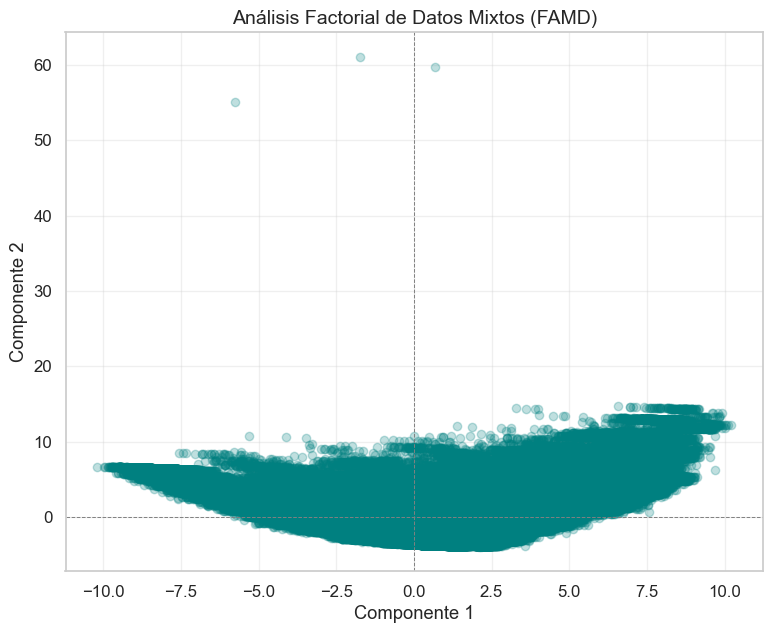

In [19]:
# Coordenadas de los individuos
row_coords = famd.row_coordinates(df_famd)

# Gráfico de individuos
plt.figure(figsize=(9,7))
plt.scatter(row_coords[0], row_coords[1], alpha=0.25, c="teal")
plt.title("Análisis Factorial de Datos Mixtos (FAMD)", fontsize=14)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.axhline(0, color="grey", linestyle="--", linewidth=0.7)
plt.axvline(0, color="grey", linestyle="--", linewidth=0.7)
plt.grid(alpha=0.3)
plt.show()

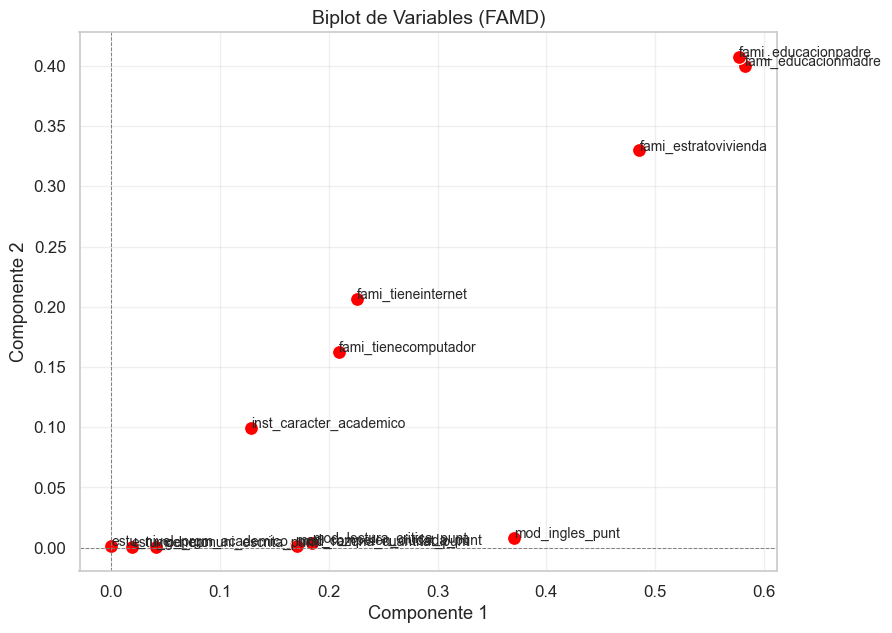

In [20]:
col_coords = famd.column_coordinates_

plt.figure(figsize=(9,7))
sns.scatterplot(x=col_coords[0], y=col_coords[1], s=100, color="red")

# Etiquetas de variables
for i, var in enumerate(col_coords.index):
    plt.text(col_coords.iloc[i,0], col_coords.iloc[i,1], var, fontsize=10)

plt.title("Biplot de Variables (FAMD)", fontsize=14)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.axhline(0, color="grey", linestyle="--", linewidth=0.7)
plt.axvline(0, color="grey", linestyle="--", linewidth=0.7)
plt.grid(alpha=0.3)
plt.show()